In [67]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from datetime import datetime
from IPython.display import display, HTML
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kruskal, pointbiserialr
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold, RFE
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import roc_curve, auc, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 3)

warnings.filterwarnings('ignore')



In [68]:
#loading the dataset

df_trustpilot = pd.read_csv('data/data_trustpilot_3.csv', engine='python')
train_df = pd.read_csv('data/train_trustpilot_3.csv', engine='python')
test_df = pd.read_csv('data/test_trustpilot_3.csv', engine='python')

# Load TF-IDF matrices
X_train_tfidf = np.load('data/X_train_tfidf.npy')
X_test_tfidf = np.load('data/X_test_tfidf.npy')
tfidf_features = np.load('data/tfidf_features.npy', allow_pickle=True)

# Load BoW matrices
X_train_bow = np.load('data/X_train_bow.npy')
X_test_bow = np.load('data/X_test_bow.npy')
bow_features = np.load('data/bow_features.npy', allow_pickle=True)


print("Dataset shapes:")
print(f"Full dataset: {df_trustpilot.shape}")
print(f"Training set: {train_df.shape}")
print(f"Test set: {test_df.shape}")

print("Text feature matrices shapes:")
print(f"TF-IDF training: {X_train_tfidf.shape}")
print(f"TF-IDF testing: {X_test_tfidf.shape}")
print(f"BoW training: {X_train_bow.shape}")
print(f"BoW testing: {X_test_bow.shape}")

display(train_df.head())



Dataset shapes:
Full dataset: (100262, 34)
Training set: (80209, 34)
Test set: (20053, 34)
Text feature matrices shapes:
TF-IDF training: (80209, 5000)
TF-IDF testing: (20053, 5000)
BoW training: (80209, 5000)
BoW testing: (20053, 5000)


,rating,location,username,number_reviews,verification,repeat_reviewer,repeat_reviewer_encoded,company,text,text_processed,text_length,text_word_length,Sentiment_Blob,Sentiment_Blob_cat,Sentiment_VADER,Sentiment_VADER_cat,subject,subject_processed,subject_length,subject_word_length,answer,answer_processed,answered_encoded,date_of_experience,date_posted,local_date_posted,month_local,local_hour,time_of_day,day_of_week_posted,day_type,days_between_experience_and_post,review_time,review_time_encoded
0,1,US,Jonah,1,Verified,one-time,0,SteelSeries,Products straight up just don’t work at all,products straight dont work,27,4,0.200,3.0,0.226,4,Products straight up just don’t work at…,products straight dont work,27,4,0,0,0,2021-08-29,2021-08-29 17:39:23,2021-08-29,8,10,Business Hours,6,Weekend,0,quick_review,1
1,5,US,Marcieb,2,Verified,repeat,1,Quicken,Easy to use. Really set up nicely to read. Reports are great for CPA taxes. Easy for elderly too.,easy use really set nicely read reports great cpa taxes easy elderly,68,12,0.493,4.0,0.920,5,Very satisfied with system.,satisfied system,16,2,0,0,0,2024-04-19,2024-04-19 16:35:21,2024-04-19,4,9,Business Hours,4,Business Day,0,quick_review,1
2,3,US,Joshua Ridenour,1,Verified,one-time,0,SCUFGaming,had it a week and the right button on the D pad,week right button pad,21,4,0.286,4.0,0.000,3,haven’t even had it a week and the right button on the d-pad stopped working,havent even week right button dpad stopped working,46,7,0,0,0,2023-11-28,2023-12-05 00:42:26,2023-12-04,12,17,Business Hours,0,Business Day,0,late_review,0
3,5,US,Kenny,1,Verified,one-time,0,Inkfarm.com,Works just as good as OEM.saved $ on order,works good oemsaved order,25,4,0.700,5.0,0.440,4,Great Fast Service,great fast service,18,3,0,0,0,2014-10-16,2014-10-16 01:09:07,2014-10-15,10,18,Evening,2,Business Day,0,quick_review,1
4,1,GB,Sandi,2,Not Verified,repeat,1,Asda,"Customer Service in this store is abysmal. Today I saw a store manager wind a customer to the point where the customer said he was going smash his face in. Granted this man was very wrong and security had to be called. A few customers saw what happened and complained to a staff there to be told by this employee ""He is a manager, he can do what he likes"" ... Really ... I have to find somewhere is to shop",customer service store abysmal today saw store manager wind customer point customer said going smash face granted man wrong security called customers saw happened complained staff told employee manager likes really find somewhere shop,234,34,-0.200,2.0,0.103,3,Asda Watford Customer Service,asda watford customer service,29,4,0,0,0,2016-01-16,2016-01-16 18:06:29,2016-01-16,1,17,Business Hours,5,Weekend,0,quick_review,1


In [69]:
#First check
df_trustpilot['local_date_posted'] = pd.to_datetime(df_trustpilot['local_date_posted'])
df_trustpilot['date_of_experience'] = pd.to_datetime(df_trustpilot['date_of_experience'])
df_trustpilot['date_posted'] = pd.to_datetime(df_trustpilot['date_posted'])
print(df_trustpilot.columns)
display(df_trustpilot.info())

train_df['local_date_posted'] = pd.to_datetime(train_df['local_date_posted'])
train_df['date_of_experience'] = pd.to_datetime(train_df['date_of_experience'])
train_df['date_posted'] = pd.to_datetime(train_df['date_posted'])
print(train_df.columns)
display(train_df.info())

test_df['local_date_posted'] = pd.to_datetime(test_df['local_date_posted'])
test_df['date_of_experience'] = pd.to_datetime(test_df['date_of_experience'])
test_df['date_posted'] = pd.to_datetime(test_df['date_posted'])
print(test_df.columns)
display(test_df.info())

Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'repeat_reviewer', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob',
       'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat',
       'subject', 'subject_processed', 'subject_length', 'subject_word_length',
       'answer', 'answer_processed', 'answered_encoded', 'date_of_experience',
       'date_posted', 'local_date_posted', 'month_local', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type',
       'days_between_experience_and_post', 'review_time',
       'review_time_encoded'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100262 entries, 0 to 100261
Data columns (total 34 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   rating                            100262 non-nul

None

Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'repeat_reviewer', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob',
       'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat',
       'subject', 'subject_processed', 'subject_length', 'subject_word_length',
       'answer', 'answer_processed', 'answered_encoded', 'date_of_experience',
       'date_posted', 'local_date_posted', 'month_local', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type',
       'days_between_experience_and_post', 'review_time',
       'review_time_encoded'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80209 entries, 0 to 80208
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            80209 non-null  in

None

Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'repeat_reviewer', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob',
       'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat',
       'subject', 'subject_processed', 'subject_length', 'subject_word_length',
       'answer', 'answer_processed', 'answered_encoded', 'date_of_experience',
       'date_posted', 'local_date_posted', 'month_local', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type',
       'days_between_experience_and_post', 'review_time',
       'review_time_encoded'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20053 entries, 0 to 20052
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            20053 non-null  in

None

STAGE 1 - HEATMAP 

In [70]:
# Split features by type
binary_variables = ['repeat_reviewer', 'repeat_reviewer_encoded', 'answered_encoded', 'day_type', 'review_time', 'review_time_encoded']
categorical_text = ['location', 'username', 'verification', 'company', 'text', 'text_processed', 'subject', 'subject_processed', 'answer', 'answer_processed', 'time_of_day']
categorical_ordinal = ['rating', 'Sentiment_Blob_cat',  'Sentiment_VADER_cat']
true_numeric = ['number_reviews', 'text_length', 'text_word_length', 'Sentiment_Blob', 'Sentiment_VADER', 'subject_length', 'subject_word_length', 'days_between_experience_and_post']
time_based_numeric = ['month_local', 'local_hour',  'day_of_week_posted']
datetime_columns = ['date_of_experience', 'date_posted', 'local_date_posted']

# Create DataFrame with numeric and ordinal features for correlation analysis
numeric_for_correlation = train_df[true_numeric + categorical_ordinal + time_based_numeric].copy()

# Create DataFrame with TF-IDF features
tfidf_df = pd.DataFrame(X_train_tfidf, columns=[f'tfidf_{i}' for i in range(X_train_tfidf.shape[1])])
top_n_tfidf = 15
top_tfidf_cols = tfidf_df.apply(lambda x: abs(x.corr(train_df['rating']))).nlargest(top_n_tfidf).index

# Create DataFrame with BoW features
bow_df = pd.DataFrame(X_train_bow, columns=[f'bow_{i}' for i in range(X_train_bow.shape[1])])
top_n_bow = 15
top_bow_cols = bow_df.apply(lambda x: abs(x.corr(train_df['rating']))).nlargest(top_n_bow).index



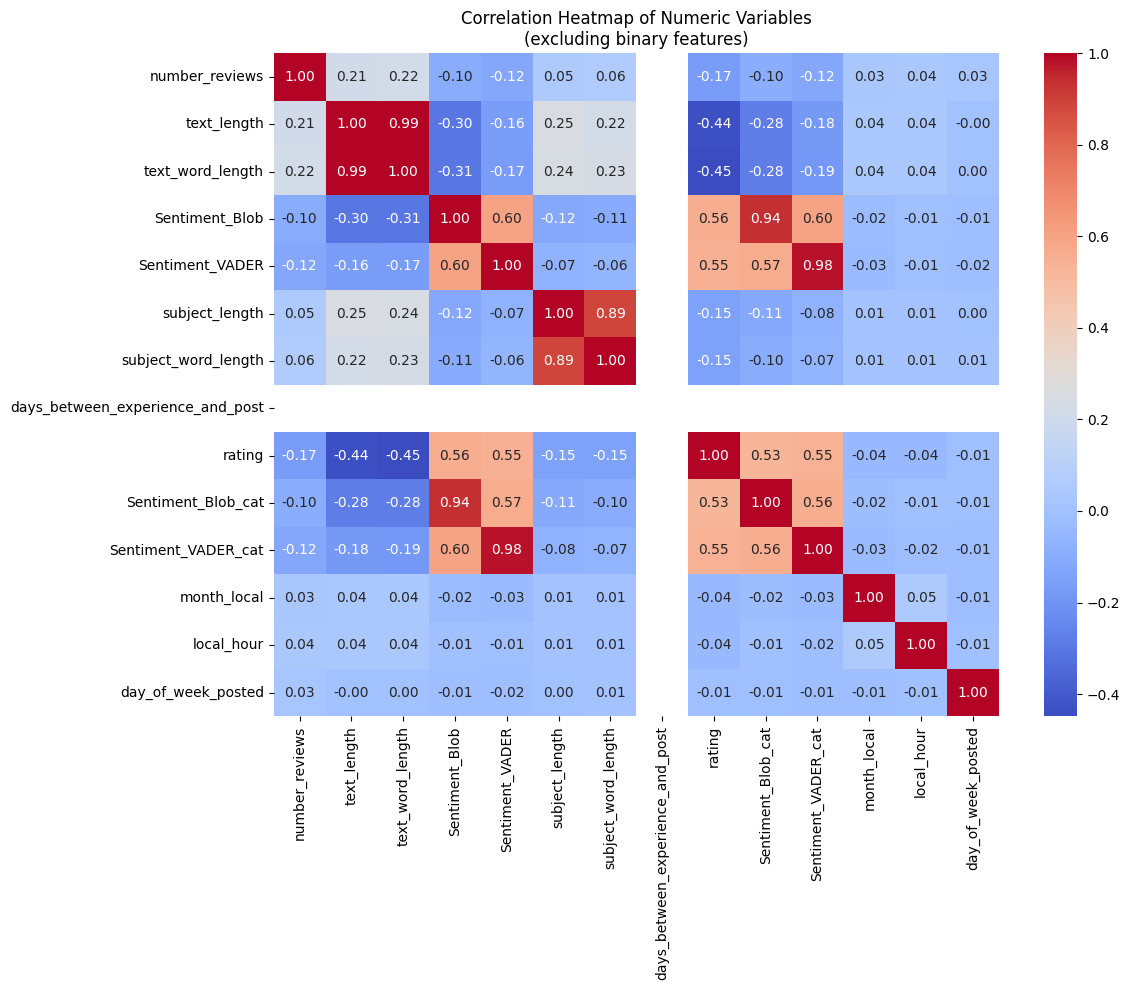

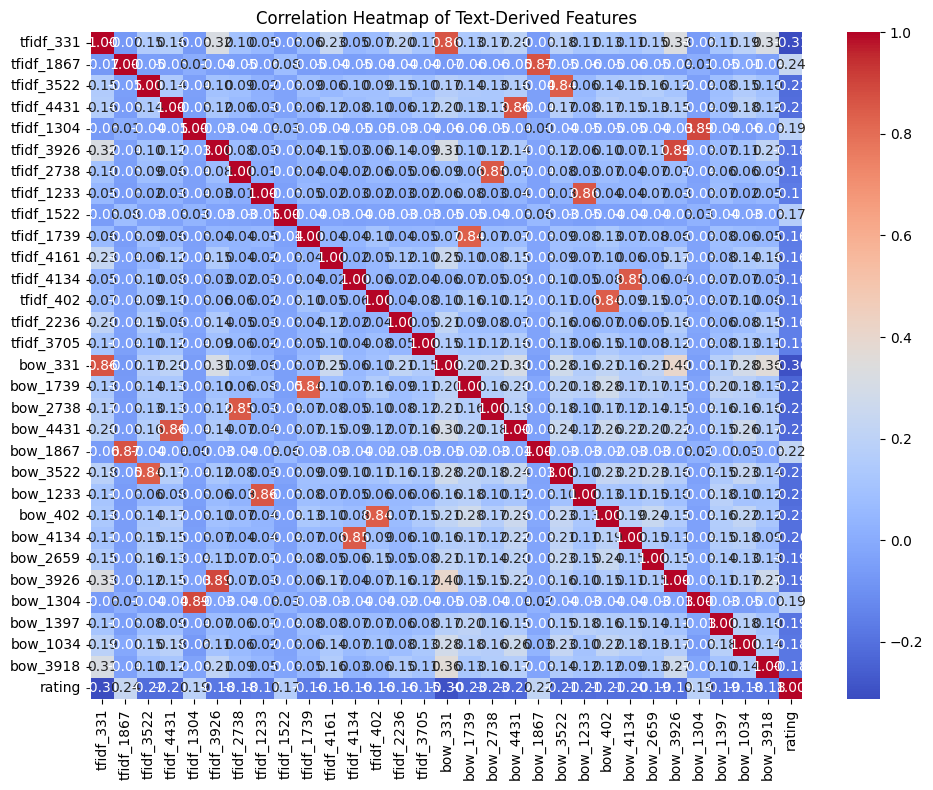

Highly correlated pairs (>0.7) with analysis:
Original Numeric Variables:
text_word_length & text_length: 0.994
Correlation with rating: text_word_length: 0.448, text_length: 0.436
Recommendation: Keep text_word_length (stronger correlation with target)
subject_word_length & subject_length: 0.889
Correlation with rating: subject_word_length: 0.148, subject_length: 0.145
Recommendation: Keep subject_word_length (stronger correlation with target)
Sentiment_Blob_cat & Sentiment_Blob: 0.938
Correlation with rating: Sentiment_Blob_cat: 0.530, Sentiment_Blob: 0.559
Recommendation: Keep Sentiment_Blob (stronger correlation with target)
Sentiment_VADER_cat & Sentiment_VADER: 0.981
Correlation with rating: Sentiment_VADER_cat: 0.547, Sentiment_VADER: 0.550
Recommendation: Keep Sentiment_VADER (stronger correlation with target)
Text-Derived Features:
bow_331 & tfidf_331: 0.864
Correlation with rating: bow_331: 0.297, tfidf_331: 0.313
Recommendation: Keep tfidf_331 (stronger correlation with targ

In [71]:
# Correlation heatmaps
# 1. True numeric and ordinal variables
original_corr = numeric_for_correlation.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(original_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Variables\n(excluding binary features)')
plt.tight_layout()
plt.show()

# 2. Text-derived features
text_features_with_rating = pd.concat([tfidf_df[top_tfidf_cols], bow_df[top_bow_cols], train_df['rating']], axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(text_features_with_rating, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Text-Derived Features')
plt.tight_layout()
plt.show()

# Analyze correlations and print results
print("Highly correlated pairs (>0.7) with analysis:")
print("Original Numeric Variables:")
for i in range(len(original_corr.columns)):
    for j in range(i):
        if abs(original_corr.iloc[i, j]) > 0.7:
            var1 = original_corr.columns[i]
            var2 = original_corr.columns[j]
            correlation = original_corr.iloc[i, j]
            corr_with_target1 = abs(original_corr.loc[var1, 'rating'])
            corr_with_target2 = abs(original_corr.loc[var2, 'rating'])
            print(f"{var1} & {var2}: {correlation:.3f}")
            print(f"Correlation with rating: {var1}: {corr_with_target1:.3f}, "
                  f"{var2}: {corr_with_target2:.3f}")
            print(f"Recommendation: Keep {var1 if corr_with_target1 > corr_with_target2 else var2} "
                  f"(stronger correlation with target)")

print("Text-Derived Features:")
for i in range(len(text_features_with_rating.columns)):
    for j in range(i):
        if abs(text_features_with_rating.iloc[i, j]) > 0.7:
            var1 = text_features_with_rating.columns[i]
            var2 = text_features_with_rating.columns[j]
            if var1 != 'rating' and var2 != 'rating':
                correlation = text_features_with_rating.iloc[i, j]
                corr_with_target1 = abs(text_features_with_rating.loc[var1, 'rating'])
                corr_with_target2 = abs(text_features_with_rating.loc[var2, 'rating'])
                print(f"{var1} & {var2}: {correlation:.3f}")
                print(f"Correlation with rating: {var1}: {corr_with_target1:.3f}, "
                      f"{var2}: {corr_with_target2:.3f}")
                print(f"Recommendation: Keep {var1 if corr_with_target1 > corr_with_target2 else var2} "
                      f"(stronger correlation with target)")

print("\nNote: Binary variables were excluded from correlation analysis as they require "
      "different statistical approaches (e.g., point-biserial correlation).")

In [72]:
# Point-biserial correlation with binary features and'rating'
for binary_var in ['repeat_reviewer_encoded', 'answered_encoded', 'review_time_encoded']:
    corr, p_value = pointbiserialr(train_df[binary_var], train_df['rating'])
    print(f"{binary_var}: Point-biserial correlation with 'rating' = {corr:.3f} (p-value = {p_value:.3e})")


repeat_reviewer_encoded: Point-biserial correlation with 'rating' = -0.076 (p-value = 8.499e-103)
answered_encoded: Point-biserial correlation with 'rating' = 0.024 (p-value = 1.507e-11)
review_time_encoded: Point-biserial correlation with 'rating' = 0.075 (p-value = 1.352e-100)


STAGE 2 - ENCODING

In [73]:
#Encoding

def encode_features(train_df, test_df):
    # 1. Ordinal Encoding
    # time_of_day encoding
    time_of_day_order = ['Morning', 'Business Hours', 'Evening', 'Night']
    train_df['time_of_day_encoded'] = pd.Categorical(
        train_df['time_of_day'], 
        categories=time_of_day_order).codes
    test_df['time_of_day_encoded'] = pd.Categorical(
        test_df['time_of_day'], 
        categories=time_of_day_order).codes
    
    # verification encoding
    verification_order = ['Verified', 'Invited', 'Redirected', 'Not Verified']
    train_df['verification_encoded'] = pd.Categorical(
        train_df['verification'], 
        categories=verification_order).codes
    test_df['verification_encoded'] = pd.Categorical(
        test_df['verification'], 
        categories=verification_order).codes
    
    # 2. Label Encoding for location
    all_locations = pd.concat([train_df['location'], test_df['location']]).unique()
    location_map = {loc: idx for idx, loc in enumerate(sorted(all_locations))}
    
    train_df['location_encoded'] = train_df['location'].map(location_map)
    test_df['location_encoded'] = test_df['location'].map(location_map)
    
    # 3. One-Hot Encoding
    for column in ['company', 'day_type']:
        all_values = pd.concat([train_df[column], test_df[column]]).unique()
        
        dummy_cols = pd.get_dummies(train_df[column], prefix=column, dtype=int)
        train_df = pd.concat([train_df, dummy_cols], axis=1)
        
        dummy_cols_test = pd.get_dummies(test_df[column], prefix=column, dtype=int)
        
        for val in all_values:
            col_name = f"{column}_{val}"
            if col_name not in dummy_cols.columns:
                train_df[col_name] = 0
            if col_name not in dummy_cols_test.columns:
                test_df[col_name] = 0
    
    return train_df, test_df

train_df, test_df = encode_features(train_df, test_df)

STAGE 3 - SCALE/NORMALIZE/STANDARDIZE

In [74]:
#Scaling and normalization

def scale_features(train_df, test_df):
   standardize_columns = [
       'text_length', 'subject_length',
       'text_word_length', 'subject_word_length',
       'days_between_experience_and_post',
       'number_reviews']
   
   normalize_columns = [
       'location_encoded',
       'verification_encoded',
       'time_of_day_encoded']
   
   std_scaler = StandardScaler()
   minmax_scaler = MinMaxScaler()
   
   if standardize_columns:
       train_df[[col + '_scaled' for col in standardize_columns]] = std_scaler.fit_transform(
           train_df[standardize_columns])
       test_df[[col + '_scaled' for col in standardize_columns]] = std_scaler.transform(
           test_df[standardize_columns])
   
   if normalize_columns:
       train_df[[col + '_normalized' for col in normalize_columns]] = minmax_scaler.fit_transform(
           train_df[normalize_columns])
       test_df[[col + '_normalized' for col in normalize_columns]] = minmax_scaler.transform(
           test_df[normalize_columns])
   
   return train_df, test_df, {'standard': std_scaler, 'minmax': minmax_scaler}

train_df, test_df, scalers = scale_features(train_df, test_df)

print("Training set statistics after scaling:")
print("Standardized features:")
print(train_df[[col for col in train_df.columns if col.endswith('_scaled')]].describe())
print("Normalized features:")
print(train_df[[col for col in train_df.columns if col.endswith('_normalized')]].describe())

Training set statistics after scaling:
Standardized features:
       text_length_scaled  subject_length_scaled  text_word_length_scaled  subject_word_length_scaled  days_between_experience_and_post_scaled  number_reviews_scaled
count           8.021e+04              8.021e+04                8.021e+04                   8.021e+04                                  80209.0              8.021e+04
mean           -7.034e-17              1.800e-16                6.201e-17                   1.252e-16                                      0.0             -6.737e-17
std             1.000e+00              1.000e+00                1.000e+00                   1.000e+00                                      0.0              1.000e+00
min            -1.207e+00             -2.378e+00               -1.170e+00                  -1.817e+00                                      0.0             -6.858e-01
25%            -7.654e-01             -7.130e-01               -7.746e-01                  -1.055e+00       

In [75]:
display(train_df.head())
print(train_df.info())

,rating,location,username,number_reviews,verification,repeat_reviewer,repeat_reviewer_encoded,company,text,text_processed,text_length,text_word_length,Sentiment_Blob,Sentiment_Blob_cat,Sentiment_VADER,Sentiment_VADER_cat,subject,subject_processed,subject_length,subject_word_length,answer,answer_processed,answered_encoded,date_of_experience,date_posted,local_date_posted,month_local,local_hour,time_of_day,day_of_week_posted,day_type,days_between_experience_and_post,review_time,review_time_encoded,time_of_day_encoded,verification_encoded,location_encoded,company_Asda,company_BeenVerified,company_CheckURL,company_ConnectWise,company_DSLExtreme,company_FreedomPop,company_HubSpot,company_HubbleConnected,company_Inkfarm.com,company_Kandco,company_LegalMatch,company_Pigeonly,company_Quicken,company_Rebtel,company_SCUFGaming,company_SmarterPhone,company_Solis,company_SpyTecGPS,company_SteelSeries,day_type_Business Day,day_type_Weekend,text_length_scaled,subject_length_scaled,text_word_length_scaled,subject_word_length_scaled,days_between_experience_and_post_scaled,number_reviews_scaled,location_encoded_normalized,verification_encoded_normalized,time_of_day_encoded_normalized
0,1,US,Jonah,1,Verified,one-time,0,SteelSeries,Products straight up just don’t work at all,products straight dont work,27,4,0.200,3.0,0.226,4,Products straight up just don’t work at…,products straight dont work,27,4,0,0,0,2021-08-29,2021-08-29 17:39:23,2021-08-29,8,10,Business Hours,6,Weekend,0,quick_review,1,1,0,160,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,-1.007,0.508,-1.001,0.471,0.0,-0.686,0.936,0.25,0.333
1,5,US,Marcieb,2,Verified,repeat,1,Quicken,Easy to use. Really set up nicely to read. Reports are great for CPA taxes. Easy for elderly too.,easy use really set nicely read reports great cpa taxes easy elderly,68,12,0.493,4.0,0.920,5,Very satisfied with system.,satisfied system,16,2,0,0,0,2024-04-19,2024-04-19 16:35:21,2024-04-19,4,9,Business Hours,4,Business Day,0,quick_review,1,1,0,160,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,-0.665,-0.713,-0.548,-1.055,0.0,-0.079,0.936,0.25,0.333
2,3,US,Joshua Ridenour,1,Verified,one-time,0,SCUFGaming,had it a week and the right button on the D pad,week right button pad,21,4,0.286,4.0,0.000,3,haven’t even had it a week and the right button on the d-pad stopped working,havent even week right button dpad stopped working,46,7,0,0,0,2023-11-28,2023-12-05 00:42:26,2023-12-04,12,17,Business Hours,0,Business Day,0,late_review,0,1,0,160,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,-1.057,2.617,-1.001,2.758,0.0,-0.686,0.936,0.25,0.333
3,5,US,Kenny,1,Verified,one-time,0,Inkfarm.com,Works just as good as OEM.saved $ on order,works good oemsaved order,25,4,0.700,5.0,0.440,4,Great Fast Service,great fast service,18,3,0,0,0,2014-10-16,2014-10-16 01:09:07,2014-10-15,10,18,Evening,2,Business Day,0,quick_review,1,2,0,160,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,-1.024,-0.491,-1.001,-0.292,0.0,-0.686,0.936,0.25,0.667
4,1,GB,Sandi,2,Not Verified,repeat,1,Asda,"Customer Service in this store is abysmal. Today I saw a store manager wind a customer to the point where the customer said he was going smash his face in. Granted this man was very wrong and security had to be called. A few customers saw what happened and complained to a staff there to be told by this employee ""He is a manager, he can do what he likes"" ... Really ... I have to find somewhere is to shop",customer service store abysmal today saw store manager wind customer point customer said going smash face granted man wrong security called customers saw happened complained staff told employee manager likes really find somewhere shop,234,34,-0.200,2.0,0.103,3,Asda Watford Customer Service,asda watford customer service,29,4,0,0,0,2016-01-16,2016-01-16 18:06:29,2016-01-16,1,17,Business Hours,5,Weekend,0,quick_review,1,1,3,57,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.719,0.730,0.696,0.471,0.0,-0.079,0.333,1.00,0.333


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80209 entries, 0 to 80208
Data columns (total 67 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   rating                                   80209 non-null  int64         
 1   location                                 80209 non-null  object        
 2   username                                 80209 non-null  object        
 3   number_reviews                           80209 non-null  int64         
 4   verification                             80209 non-null  object        
 5   repeat_reviewer                          80209 non-null  object        
 6   repeat_reviewer_encoded                  80209 non-null  int64         
 7   company                                  80209 non-null  object        
 8   text                                     80209 non-null  object        
 9   text_processed                         

In [76]:
#Split variables by type
#Cannot be used in statistical tests
text_content = ['text', 'text_processed', 'subject', 'subject_processed', 'answer', 'answer_processed', 'username']
raw_categorical = ['day_type', 'review_time', 'repeat_reviewer', 'company', 'location',  'verification', 'time_of_day', 'date_of_experience', 'date_posted', 'local_date_posted']

#Can be used in statistical tests
binary_variables = ['repeat_reviewer_encoded', 'answered_encoded', 'review_time_encoded',  'day_type_Business Day', 'day_type_Weekend']
categorical_ordinal = ['Sentiment_Blob_cat',  'Sentiment_VADER_cat', 'time_of_day_encoded', 'verification_encoded']
categorical_nominal = ['location_encoded']
true_numeric = ['number_reviews', 'text_length', 'text_word_length', 'Sentiment_Blob', 'Sentiment_VADER', 'subject_length', 'subject_word_length', 'days_between_experience_and_post', 'text_length_scaled', 'subject_length_scaled', 'text_word_length_scaled', 'subject_word_length_scaled', 'days_between_experience_and_post_scaled', 'number_reviews_scaled', 'location_encoded_normalized', 'verification_encoded_normalized', 'time_of_day_encoded_normalized']
time_based_numeric = ['month_local', 'local_hour',  'day_of_week_posted']

full_set = binary_variables + categorical_nominal + categorical_ordinal + text_content + true_numeric + time_based_numeric + raw_categorical
print(len(full_set))

statistical_features = binary_variables + categorical_ordinal + categorical_nominal + true_numeric + time_based_numeric

47


STAGE 4 - VARIANCE THRESHOLD

In [77]:
def calculate_variance_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    v_threshold = VarianceThreshold(threshold = 0.001)
    v_threshold.fit(train_df[statistical_features])
    regular_variances = dict(zip(statistical_features, [float(x) for x in v_threshold.variances_]))
    
    v_threshold.fit(X_train_tfidf)
    tfidf_variances = dict(zip(top_tfidf_cols, [float(x) for x in v_threshold.variances_]))
    
    v_threshold.fit(X_train_bow)
    bow_variances = dict(zip(top_bow_cols, [float(x) for x in v_threshold.variances_]))
    
    return {**regular_variances, **tfidf_variances, **bow_variances}

variance_scores = calculate_variance_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)


STAGE 5 - MEAN ABSOLUTE DIFFERENCE

In [78]:
#Mean Absolute Difference
def calculate_mad_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    regular_mad = dict(zip(statistical_features, 
                          [float(np.sum(np.abs(train_df[feature] - np.mean(train_df[feature]))) / len(train_df)) 
                           for feature in statistical_features]))
    tfidf_mad = dict(zip(top_tfidf_cols,
                        [float(np.sum(np.abs(X_train_tfidf[:, i] - np.mean(X_train_tfidf[:, i]))) / len(X_train_tfidf))
                         for i in range(len(top_tfidf_cols))]))
    bow_mad = dict(zip(top_bow_cols,
                      [float(np.sum(np.abs(X_train_bow[:, i] - np.mean(X_train_bow[:, i]))) / len(X_train_bow))
                       for i in range(len(top_bow_cols))]))
    
    all_mad = {**regular_mad, **tfidf_mad, **bow_mad}
    return all_mad

mad_scores = calculate_mad_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)


STAGE 6 - PEARSON AND SPEARMAN

In [79]:
#Pearson and Spearman
def calculate_correlation_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    correlations = {}
    for feature in statistical_features:
        pearson_coef, pearson_p = pearsonr(train_df['rating'], train_df[feature])
        spearman_coef, spearman_p = spearmanr(train_df['rating'], train_df[feature])
        correlations[feature] = {
            'pearson_coef': float(pearson_coef),
            'pearson_p': float(pearson_p),
            'spearman_coef': float(spearman_coef),
            'spearman_p': float(spearman_p)}
    for i, feature in enumerate(top_tfidf_cols):
        pearson_coef, pearson_p = pearsonr(train_df['rating'], X_train_tfidf[:, i])
        spearman_coef, spearman_p = spearmanr(train_df['rating'], X_train_tfidf[:, i])
        correlations[feature] = {
            'pearson_coef': float(pearson_coef),
            'pearson_p': float(pearson_p),
            'spearman_coef': float(spearman_coef),
            'spearman_p': float(spearman_p)}
    for i, feature in enumerate(top_bow_cols):
        pearson_coef, pearson_p = pearsonr(train_df['rating'], X_train_bow[:, i])
        spearman_coef, spearman_p = spearmanr(train_df['rating'], X_train_bow[:, i])
        correlations[feature] = {
            'pearson_coef': float(pearson_coef),
            'pearson_p': float(pearson_p),
            'spearman_coef': float(spearman_coef),
            'spearman_p': float(spearman_p)}
    
    return correlations

correlation_scores = calculate_correlation_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)


STAGE 7 - ANOVA

In [80]:
#Anova

def calculate_anova_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):

    anova_results = {}
    
    for feature in statistical_features:
        df_temp = pd.DataFrame({
            'feature_value': train_df[feature],
            'rating': train_df['rating']})
        result = smf.ols('feature_value ~ C(rating)', data=df_temp).fit()
        table = sm.stats.anova_lm(result)
        anova_results[feature] = {
            'f_stat': float(table['F'][0]),
            'p_value': float(table['PR(>F)'][0])}
    
    for i, feature in enumerate(top_tfidf_cols):
        df_temp = pd.DataFrame({
            'feature_value': X_train_tfidf[:, i],
            'rating': train_df['rating']})
        result = smf.ols('feature_value ~ rating', data=df_temp).fit()
        table = sm.stats.anova_lm(result)
        anova_results[feature] = {
            'f_stat': float(table['F'][0]),
            'p_value': float(table['PR(>F)'][0])}
    
    for i, feature in enumerate(top_bow_cols):
        df_temp = pd.DataFrame({
            'feature_value': X_train_bow[:, i],
            'rating': train_df['rating']})
        result = smf.ols('feature_value ~ rating', data=df_temp).fit()
        table = sm.stats.anova_lm(result)
        anova_results[feature] = {
            'f_stat': float(table['F'][0]),
            'p_value': float(table['PR(>F)'][0])}
    
    return anova_results

anova_scores = calculate_anova_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)


STAGE 8 - MUTUAL INFORMATION

In [81]:
# Mutual Information
tfidf_features = X_train_tfidf[:, :len(top_tfidf_cols)]
bow_features = X_train_bow[:, :len(top_bow_cols)]

X = np.hstack([
    train_df[statistical_features].values,
    X_train_tfidf[:, :len(top_tfidf_cols)],
    X_train_bow[:, :len(top_bow_cols)]])

all_columns = (statistical_features + 
              list(top_tfidf_cols) + 
              list(top_bow_cols))

importances = mutual_info_classif(X, train_df['rating'])
feat_importances = pd.Series(importances, index=all_columns)
mi_scores = {k: float(v) for k, v in feat_importances.to_dict().items()}


STAGE 9 - KRUSKAL-WALLIS TEST

In [82]:
#Kruskal-Wallis Test

def calculate_kruskal_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    kruskal_scores = {}  
    
    for feature in statistical_features:
        if feature in train_df.columns:
            groups = [train_df[feature][train_df['rating'] == level] 
                     for level in train_df['rating'].unique()]
            try:
                statistic, p_value = kruskal(*groups)
                kruskal_scores[feature] = {'statistic': float(statistic), 'p_value': float(p_value)}
                print(f"{feature}: statistic={statistic:.6f}, p-value={p_value:.6f}")
            except ValueError:
                continue

    if X_train_tfidf is not None:
        for i, feature in enumerate(top_tfidf_cols):
            groups = [X_train_tfidf[:, i][train_df['rating'] == level] 
                     for level in train_df['rating'].unique()]
            try:
                statistic, p_value = kruskal(*groups)
                kruskal_scores[feature] = {'statistic': float(statistic), 'p_value': float(p_value)}
                print(f"{feature}: statistic={statistic:.6f}, p-value={p_value:.6f}")
            except ValueError:
                continue

    if X_train_bow is not None:
        for i, feature in enumerate(top_bow_cols):
            groups = [X_train_bow[:, i][train_df['rating'] == level] 
                     for level in train_df['rating'].unique()]
            try:
                statistic, p_value = kruskal(*groups)
                kruskal_scores[feature] = {'statistic': float(statistic), 'p_value': float(p_value)}
                print(f"{feature}: statistic={statistic:.6f}, p-value={p_value:.6f}")
            except ValueError:
                continue
    
    return kruskal_scores

kruskal_scores = calculate_kruskal_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)


repeat_reviewer_encoded: statistic=785.146585, p-value=0.000000
answered_encoded: statistic=539.419892, p-value=0.000000
review_time_encoded: statistic=863.938747, p-value=0.000000
day_type_Business Day: statistic=36.837439, p-value=0.000000
day_type_Weekend: statistic=36.837439, p-value=0.000000
Sentiment_Blob_cat: statistic=24468.374300, p-value=0.000000
Sentiment_VADER_cat: statistic=22286.467901, p-value=0.000000
time_of_day_encoded: statistic=297.083028, p-value=0.000000
verification_encoded: statistic=11009.501723, p-value=0.000000
location_encoded: statistic=8602.141205, p-value=0.000000
number_reviews: statistic=1832.030619, p-value=0.000000
text_length: statistic=14183.493158, p-value=0.000000
text_word_length: statistic=14973.151604, p-value=0.000000
Sentiment_Blob: statistic=28053.430223, p-value=0.000000
Sentiment_VADER: statistic=21545.730810, p-value=0.000000
subject_length: statistic=1690.457877, p-value=0.000000
subject_word_length: statistic=1758.364937, p-value=0.0000

STAGE 10 - RECURSIVE FEATURE ELIMINATION

In [83]:
#Recursive Feature Elimination

def analyze_recursive_feature_elimination(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    global rfe_ranks

    X = train_df[statistical_features].fillna(0)
    
    if isinstance(X_train_tfidf, np.ndarray):
        tfidf_df = pd.DataFrame(
            X_train_tfidf[:, :len(top_tfidf_cols)],
            columns=top_tfidf_cols)
        X = pd.concat([X, tfidf_df], axis=1)
        statistical_features.extend(top_tfidf_cols)
    if isinstance(X_train_bow, np.ndarray):
        bow_df = pd.DataFrame(
            X_train_bow[:, :len(top_bow_cols)],
            columns=top_bow_cols)
        X = pd.concat([X, bow_df], axis=1)
        statistical_features.extend(top_bow_cols)
    
    y = train_df['rating']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    estimator = LogisticRegression(max_iter=5000, multi_class='multinomial', random_state=42)
    selector = RFE(estimator=estimator, n_features_to_select=10, step=1)
    selector.fit(X_scaled, y)
    
    rfe_ranks = dict(zip(X.columns, selector.ranking_))
    rfe_ranks = {k: int(v) for k, v in rfe_ranks.items()}  
    selected_features = X.columns[selector.support_].tolist()
    
    print(f"Number of features selected: {len(selected_features)}")
    print(f"Selected features: {', '.join(selected_features)}")
    
    ranked_features = {}
    for feature, rank in rfe_ranks.items():
        if rank not in ranked_features:
            ranked_features[rank] = []
        ranked_features[rank].append(feature)
    for rank in sorted(ranked_features.keys()):
        features = ranked_features[rank]
        status = "SELECTED" if rank == 1 else f"Eliminated (Round {rank-1})"
        print(f"Rank {rank} - {status}:")
        for feature in sorted(features):
            print(f" - {feature}")
    return {'selected_features': selected_features, 'ranked_features': ranked_features}

try:
    rfe_results = analyze_recursive_feature_elimination(
        train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)
except Exception as e:
    print(f"Error during analysis: {str(e)}")

Number of features selected: 10
Selected features: answered_encoded, Sentiment_VADER_cat, text_length, text_word_length, Sentiment_Blob, Sentiment_VADER, text_length_scaled, text_word_length_scaled, verification_encoded_normalized, tfidf_2738
Rank 1 - SELECTED:
 - Sentiment_Blob
 - Sentiment_VADER
 - Sentiment_VADER_cat
 - answered_encoded
 - text_length
 - text_length_scaled
 - text_word_length
 - text_word_length_scaled
 - tfidf_2738
 - verification_encoded_normalized
Rank 2 - Eliminated (Round 1):
 - location_encoded_normalized
Rank 3 - Eliminated (Round 2):
 - verification_encoded
Rank 4 - Eliminated (Round 3):
 - review_time_encoded
Rank 5 - Eliminated (Round 4):
 - bow_1233
Rank 6 - Eliminated (Round 5):
 - location_encoded
Rank 7 - Eliminated (Round 6):
 - bow_2659
Rank 8 - Eliminated (Round 7):
 - subject_length
Rank 9 - Eliminated (Round 8):
 - subject_word_length_scaled
Rank 10 - Eliminated (Round 9):
 - tfidf_1739
Rank 11 - Eliminated (Round 10):
 - repeat_reviewer_encoded
R

STAGE 11 - LASSO

In [84]:
#Lasso

def analyze_lasso_feature_selection(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    global lasso_coef
    features_to_check = list(set(true_numeric + time_based_numeric + binary_variables + categorical_ordinal + categorical_nominal))
    
    X = train_df[features_to_check].fillna(0)
    
    if isinstance(X_train_tfidf, np.ndarray):
        tfidf_df = pd.DataFrame(
            X_train_tfidf[:, :len(top_tfidf_cols)],
            columns=top_tfidf_cols)
        X = pd.concat([X, tfidf_df], axis=1)
        features_to_check.extend(top_tfidf_cols)
    if isinstance(X_train_bow, np.ndarray):
        bow_df = pd.DataFrame(
            X_train_bow[:, :len(top_bow_cols)],
            columns=top_bow_cols)
        X = pd.concat([X, bow_df], axis=1)
        features_to_check.extend(top_bow_cols)
    
    y = train_df['rating']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    lasso = LassoCV(cv=5, random_state=42, max_iter=2000)
    lasso.fit(X_scaled, y)
    
    lasso_coef = dict(zip(X.columns, lasso.coef_))
    lasso_coef = {k: float(v) for k, v in lasso_coef.items()}  
    
    print(f"Best alpha: {lasso.alpha_:.6f}")
    
    for feature, coef in sorted(lasso_coef.items(), key=lambda x: abs(x[1]), reverse=True):
        importance = ("strong" if abs(coef) >= 0.5 else
            "moderate" if abs(coef) >= 0.1 else
            "weak" if abs(coef) >= 0.01 else
            "very weak" if abs(coef) > 0 else
            "eliminated")
        print(f"{feature}: {coef:.6f} ({importance})")
    return {'best_alpha': lasso.alpha_}

try:
    lasso_results = analyze_lasso_feature_selection(
        train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)
except Exception as e:
    print(f"Error during analysis: {str(e)}")

Best alpha: 0.000929
text_word_length_scaled: -1.029284 (strong)
Sentiment_VADER: 0.583121 (strong)
text_length: 0.467148 (moderate)
Sentiment_Blob: 0.344215 (moderate)
text_length_scaled: 0.321123 (moderate)
verification_encoded: -0.190683 (moderate)
text_word_length: -0.169478 (moderate)
review_time_encoded: 0.106149 (moderate)
location_encoded: 0.104221 (moderate)
answered_encoded: -0.088729 (weak)
Sentiment_Blob_cat: 0.082172 (weak)
repeat_reviewer_encoded: 0.054293 (weak)
Sentiment_VADER_cat: -0.052969 (weak)
bow_1233: 0.044636 (weak)
subject_word_length_scaled: -0.036199 (weak)
number_reviews_scaled: -0.028174 (weak)
time_of_day_encoded_normalized: 0.021441 (weak)
tfidf_4431: 0.020478 (weak)
tfidf_1867: -0.020033 (weak)
tfidf_3926: -0.019779 (weak)
day_type_Weekend: -0.018332 (weak)
day_of_week_posted: 0.015915 (weak)
local_hour: -0.015557 (weak)
tfidf_1304: 0.014848 (weak)
bow_1739: 0.013157 (weak)
tfidf_1522: -0.012948 (weak)
tfidf_4161: -0.010129 (weak)
bow_1034: -0.009921 (ve

STAGE 12 - RANDOM FOREST IMPORTANCE

In [85]:
#Random Forest Importance

def analyze_random_forest_importance(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    global rf_importance
    
    features_to_check = list(set(true_numeric + time_based_numeric + binary_variables + categorical_ordinal + categorical_nominal))
    
    X = train_df[features_to_check].fillna(0)
    
    if isinstance(X_train_tfidf, np.ndarray):
        tfidf_df = pd.DataFrame(
            X_train_tfidf[:, :len(top_tfidf_cols)],
            columns=top_tfidf_cols)
        X = pd.concat([X, tfidf_df], axis=1)
        features_to_check.extend(top_tfidf_cols)
        
    if isinstance(X_train_bow, np.ndarray):
        bow_df = pd.DataFrame(
            X_train_bow[:, :len(top_bow_cols)],
            columns=top_bow_cols)
        X = pd.concat([X, bow_df], axis=1)
        features_to_check.extend(top_bow_cols)
    
    y = train_df['rating']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5,
                              min_samples_leaf=2, random_state=42)
    rf.fit(X_scaled, y)
    
    rf_importance = dict(zip(X.columns, rf.feature_importances_))
    rf_importance = {k: float(v) for k, v in rf_importance.items()}
    
    mean_importance = np.mean(list(rf_importance.values()))
    std_importance = np.std(list(rf_importance.values()))
    
    for feature, importance in sorted(rf_importance.items(), key=lambda x: x[1], reverse=True):
        if importance > mean_importance + std_importance:
            status = "Very Important"
        elif importance > mean_importance:
            status = "Important"
        elif importance < mean_importance - std_importance:
            status = "Consider Dropping"
        else:
            status = "Review"
        print(f"{feature}: {importance:.6f} ({status})")
    
    return {'mean_importance': float(mean_importance), 'std_importance': float(std_importance)}

try:
    rf_results = analyze_random_forest_importance(
        train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)
except Exception as e:
    print(f"Error during analysis: {str(e)}")

Sentiment_Blob: 0.146802 (Very Important)
Sentiment_VADER: 0.138501 (Very Important)
Sentiment_Blob_cat: 0.136900 (Very Important)
Sentiment_VADER_cat: 0.100903 (Very Important)
verification_encoded: 0.065197 (Very Important)
verification_encoded_normalized: 0.064997 (Very Important)
text_word_length_scaled: 0.051835 (Very Important)
text_word_length: 0.048598 (Important)
text_length_scaled: 0.044443 (Important)
text_length: 0.043736 (Important)
location_encoded_normalized: 0.035557 (Important)
location_encoded: 0.032012 (Important)
number_reviews: 0.011074 (Review)
answered_encoded: 0.009510 (Review)
number_reviews_scaled: 0.008809 (Review)
subject_length: 0.007889 (Review)
subject_length_scaled: 0.007156 (Review)
local_hour: 0.006198 (Review)
review_time_encoded: 0.006010 (Review)
subject_word_length_scaled: 0.005677 (Review)
month_local: 0.005439 (Review)
subject_word_length: 0.004016 (Review)
day_of_week_posted: 0.003519 (Review)
repeat_reviewer_encoded: 0.003224 (Review)
time_of_d

STAGE 13 - LOGISTIC REGRESSION WITH RIB RATIO STUDY

In [86]:
#Logistic Regression with RIB Ratio study

def calculate_rib_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    global rib_analysis
    rib_analysis = {}
    
    def analyze_feature(X, feature_name):
        try:
            y = (train_df['rating'] >= 4).astype(int)
            X = X.reshape(-1, 1)
            
            n_bins = 10 if len(np.unique(X)) > 2 else 2
            bins = np.percentile(X.ravel(), np.linspace(0, 100, n_bins))
            bin_indices = np.digitize(X.ravel(), bins)
            
            rib_ratios = []
            for i in range(1, len(bins) + 1):
                mask = bin_indices == i
                if sum(mask) > 0:
                    ratio = np.mean(y[mask]) / (1 - np.mean(y[mask]) + 1e-10)
                    rib_ratios.append(ratio)
            
            rib_stability = float(np.std(rib_ratios) / (np.mean(rib_ratios) + 1e-10))
            rib_range = float(max(rib_ratios) - min(rib_ratios))
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            model = LogisticRegression(random_state=42, max_iter=1000)
            model.fit(X_train, y_train)
            
            odds_ratio = float(np.exp(model.coef_[0][0]))
            auc_score = float(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
            
            correlation, p_value = stats.pointbiserialr(y, X.ravel())
            
            metrics = {'auc': auc_score,
                'rib_range': rib_range,
                'rib_stability': rib_stability,
                'p_value': float(p_value),
                'odds_ratio': odds_ratio,
                'correlation': float(correlation)}
            
            rib_analysis[feature_name] = metrics
            print(f"{feature_name}:")
            print(f"  AUC: {auc_score:.3f}")
            print(f"  RIB range: {rib_range:.3f}")
            print(f"  RIB stability: {rib_stability:.3f}")
            print(f"  Odds ratio: {odds_ratio:.3f}")
            print(f"  p-value: {p_value:.6f}")
            print(f"  Correlation: {correlation:.3f}\n")
            
        except Exception as e:
            print(f"Error analyzing {feature_name}: {str(e)}")
    
    for feature in statistical_features:
        if feature in train_df.columns:
            analyze_feature(train_df[feature].values, feature)
    
    if isinstance(X_train_tfidf, np.ndarray):
        for i, feature in enumerate(top_tfidf_cols):
            analyze_feature(X_train_tfidf[:, i], feature)
    
    if isinstance(X_train_bow, np.ndarray):
        for i, feature in enumerate(top_bow_cols):
            analyze_feature(X_train_bow[:, i], feature)
    
    return rib_analysis

rib_analysis = calculate_rib_scores(train_df, X_train_tfidf, X_train_bow, 
                                  top_tfidf_cols, top_bow_cols)

repeat_reviewer_encoded:
  AUC: 0.527
  RIB range: 0.325
  RIB stability: 0.113
  Odds ratio: 0.794
  p-value: 0.000000
  Correlation: -0.056

answered_encoded:
  AUC: 0.504
  RIB range: 0.122
  RIB stability: 0.041
  Odds ratio: 1.097
  p-value: 0.000000
  Correlation: 0.018

review_time_encoded:
  AUC: 0.535
  RIB range: 0.552
  RIB stability: 0.210
  Odds ratio: 1.548
  p-value: 0.000000
  Correlation: 0.089

day_type_Business Day:
  AUC: 0.505
  RIB range: 0.109
  RIB stability: 0.039
  Odds ratio: 1.087
  p-value: 0.000004
  Correlation: 0.016

day_type_Weekend:
  AUC: 0.505
  RIB range: 0.109
  RIB stability: 0.039
  Odds ratio: 0.919
  p-value: 0.000004
  Correlation: -0.016

Sentiment_Blob_cat:
  AUC: 0.785
  RIB range: 17.993
  RIB stability: 1.199
  Odds ratio: 6.572
  p-value: 0.000000
  Correlation: 0.512

Sentiment_VADER_cat:
  AUC: 0.784
  RIB range: 4.530
  RIB stability: 1.081
  Odds ratio: 2.605
  p-value: 0.000000
  Correlation: 0.519

time_of_day_encoded:
  AUC: 0.50

STAGE 14 - MULTICOLLINEARITY CHECK

In [87]:
def check_multicollinearity(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols, threshold=0.7):
    clean_features = [f for f in statistical_features if not (f.startswith('tfidf_') or f.startswith('bow_'))]
    X = train_df[clean_features].copy()
    if isinstance(X_train_tfidf, np.ndarray):
        X = pd.concat([X, pd.DataFrame(X_train_tfidf[:, :len(top_tfidf_cols)], columns=top_tfidf_cols)], axis=1)
    if isinstance(X_train_bow, np.ndarray):
        X = pd.concat([X, pd.DataFrame(X_train_bow[:, :len(top_bow_cols)], columns=top_bow_cols)], axis=1)
    corr_matrix = X.corr()
    
    def determine_feature_to_keep(feat1, feat2):
        if feat1 == feat2:
            return None, None, "Self-correlation"
        base_feat1 = feat1.replace('_scaled', '').replace('_normalized', '').replace('_cat', '')
        base_feat2 = feat2.replace('_scaled', '').replace('_normalized', '').replace('_cat', '')
        if base_feat1 == base_feat2:
            if '_cat' in feat2 or '_cat' in feat1:
                non_cat = feat1 if '_cat' not in feat1 else feat2
                cat = feat2 if '_cat' in feat2 else feat1
                return non_cat, cat, "Keep original version over categorical"
            if '_normalized' in feat1: return feat1, feat2, "Keep normalized version"
            if '_normalized' in feat2: return feat2, feat1, "Keep normalized version"
            if '_scaled' in feat1: return feat1, feat2, "Keep scaled version"
            if '_scaled' in feat2: return feat2, feat1, "Keep scaled version"
        corr1 = abs(train_df['rating'].corr(X[feat1]))
        corr2 = abs(train_df['rating'].corr(X[feat2]))
        if (feat1.startswith('tfidf_') and feat2.startswith('bow_')) or (feat2.startswith('tfidf_') and feat1.startswith('bow_')):
            return (feat1, feat2, "Stronger correlation with target") if corr1 > corr2 else (feat2, feat1, "Stronger correlation with target")
        return (feat1, feat2, "Stronger correlation with target") if corr1 > corr2 else (feat2, feat1, "Stronger correlation with target")
    
    high_correlations = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                feat1 = corr_matrix.columns[i]
                feat2 = corr_matrix.columns[j]
                keep, drop, reason = determine_feature_to_keep(feat1, feat2)
                if keep and drop:
                    high_correlations.append({
                        'Feature1': feat1,
                        'Feature2': feat2,
                        'Correlation': abs(corr_matrix.iloc[i, j]),
                        'Keep': keep,
                        'Drop': drop,
                        'Reason': reason
                    })
    
    if high_correlations:
        results = pd.DataFrame(high_correlations).sort_values('Correlation', ascending=False)
        features_to_drop = set(results['Drop'])
        
        print(f"Recommended features to drop ({len(features_to_drop)}):")
        for feature in sorted(features_to_drop):
            row = results[results['Drop'] == feature].iloc[0]
            print(f"- Drop {feature} (correlates with {row['Keep']}, reason: {row['Reason']})")
        
        recommended_features = [f for f in X.columns if f not in features_to_drop]
        return results, recommended_features, X.columns.tolist()
    else:
        print("No high correlations found among the features.")
        return None, X.columns.tolist(), X.columns.tolist()

correlation_results, recommended_features, all_features = check_multicollinearity(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)

Recommended features to drop (30):
- Drop Sentiment_Blob_cat (correlates with Sentiment_Blob, reason: Keep original version over categorical)
- Drop Sentiment_VADER_cat (correlates with Sentiment_VADER, reason: Keep original version over categorical)
- Drop bow_1233 (correlates with tfidf_2738, reason: Stronger correlation with target)
- Drop bow_4431 (correlates with tfidf_4431, reason: Stronger correlation with target)
- Drop day_of_week_posted (correlates with day_type_Weekend, reason: Stronger correlation with target)
- Drop day_type_Business Day (correlates with day_type_Weekend, reason: Stronger correlation with target)
- Drop location_encoded (correlates with location_encoded_normalized, reason: Keep normalized version)
- Drop number_reviews (correlates with number_reviews_scaled, reason: Keep scaled version)
- Drop repeat_reviewer_encoded (correlates with number_reviews_scaled, reason: Stronger correlation with target)
- Drop subject_length (correlates with subject_length_scale

STAGE 15 - FEATURE SELECTION

In [88]:
#Add the top TF-IDF and BoW Features to dasets to have a complete set

train_df = pd.concat([train_df,
    pd.DataFrame(X_train_tfidf[:, :len(top_tfidf_cols)], columns=top_tfidf_cols),
    pd.DataFrame(X_train_bow[:, :len(top_bow_cols)], columns=top_bow_cols)], axis=1)

test_df = pd.concat([test_df,
    pd.DataFrame(X_test_tfidf[:, :len(top_tfidf_cols)], columns=top_tfidf_cols),
    pd.DataFrame(X_test_bow[:, :len(top_bow_cols)], columns=top_bow_cols)], axis=1)

all_columns = list(set(train_df.columns) & set(test_df.columns)) 
train_df = train_df[all_columns]
test_df = test_df[all_columns]

print(f"Train shape after adding text features: {train_df.shape}")
print(f"Test shape after adding text features: {test_df.shape}")


Train shape after adding text features: (80209, 76)
Test shape after adding text features: (20053, 76)


In [89]:
#Remove non-numeric columns
columns_to_drop = text_content + raw_categorical
train_df = train_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)

In [90]:
#Drop multicollinearity features

features_to_drop = set(correlation_results['Drop'])
features_to_drop = [f for f in features_to_drop if f in train_df.columns]
train_df = train_df.drop(features_to_drop, axis=1)
test_df = test_df.drop(features_to_drop, axis=1)

print(f"Train shape after dropping correlated features: {train_df.shape}")
print(f"Test shape after dropping correlated features: {test_df.shape}")

Train shape after dropping correlated features: (80209, 30)
Test shape after dropping correlated features: (20053, 30)


In [91]:
#Interpret statistical test results in combination with cross-validation to determien final feature selection

def create_statistical_results_tables(train_df, variance_scores, mad_scores, correlation_scores, 
                                    anova_scores, mi_scores, kruskal_scores, rfe_ranks,
                                    lasso_coef, rf_importance, rib_analysis):
    results_df = pd.DataFrame(index=train_df.columns)
    
    # Basic statistics
    results_df['Variance'] = pd.Series(variance_scores)
    results_df['MAD'] = pd.Series(mad_scores)
    
    # Correlation results
    results_df['Pearson_Coef'] = results_df.index.map(lambda x: correlation_scores.get(x, {}).get('pearson_coef', np.nan))
    results_df['Pearson_P'] = results_df.index.map(lambda x: correlation_scores.get(x, {}).get('pearson_p', np.nan))
    results_df['Spearman_Coef'] = results_df.index.map(lambda x: correlation_scores.get(x, {}).get('spearman_coef', np.nan))
    results_df['Spearman_P'] = results_df.index.map(lambda x: correlation_scores.get(x, {}).get('spearman_p', np.nan))
    
    # ANOVA results
    results_df['ANOVA_F'] = results_df.index.map(lambda x: anova_scores.get(x, {}).get('f_stat', np.nan))
    results_df['ANOVA_P'] = results_df.index.map(lambda x: anova_scores.get(x, {}).get('p_value', np.nan))
    
    # Other test results
    results_df['MI_Score'] = pd.Series(mi_scores)
    results_df['Kruskal_Stat'] = results_df.index.map(lambda x: kruskal_scores.get(x, {}).get('statistic', np.nan))
    results_df['Kruskal_P'] = results_df.index.map(lambda x: kruskal_scores.get(x, {}).get('p_value', np.nan))
    results_df['RFE_Rank'] = pd.Series(rfe_ranks)

    # Table 2: Interpretations
    interpretations_df = pd.DataFrame(index=train_df.columns)
    
    # Variance interpretation (using mean as threshold)
    mean_variance = np.mean(list(variance_scores.values()))
    interpretations_df['Variance'] = results_df['Variance'].apply(lambda x: 'Keep' if x > mean_variance else 'Drop')
    
    # MAD interpretation (using mean as threshold)
    mean_mad = np.mean(list(mad_scores.values()))
    interpretations_df['MAD'] = results_df['MAD'].apply(lambda x: 'Keep' if x > mean_mad else 'Drop')
    
    # Correlation interpretation
    interpretations_df['Correlation'] = results_df.apply(
        lambda x: 'Keep' if (abs(x['Pearson_Coef']) > 0.1 and x['Pearson_P'] < 0.05) or 
                           (abs(x['Spearman_Coef']) > 0.1 and x['Spearman_P'] < 0.05) else 'Drop', axis=1)
    
    # ANOVA interpretation
    interpretations_df['ANOVA'] = results_df['ANOVA_P'].apply(lambda x: 'Keep' if x < 0.05 else 'Drop')
    
    # MI Score interpretation (using mean as threshold)
    mean_mi = np.mean(list(mi_scores.values()))
    interpretations_df['MI_Score'] = results_df['MI_Score'].apply(lambda x: 'Keep' if x > mean_mi else 'Drop')
    
    # Kruskal interpretation
    interpretations_df['Kruskal'] = results_df['Kruskal_P'].apply(lambda x: 'Keep' if x < 0.05 else 'Drop')
    
    # RFE interpretation
    interpretations_df['RFE'] = results_df['RFE_Rank'].apply(lambda x: 'Keep' if x <= 10 else 'Drop')

    # Table 3: Model-based Results
    model_results_df = pd.DataFrame(index=train_df.columns)
    
    # LASSO results
    model_results_df['LASSO_Coef'] = pd.Series(lasso_coef)
    
    # Random Forest results
    model_results_df['RF_Importance'] = pd.Series(rf_importance)
    
    # RIB results
    for metric in ['auc', 'rib_range', 'rib_stability', 'p_value', 'odds_ratio', 'correlation']:
        model_results_df[f'RIB_{metric}'] = model_results_df.index.map(
            lambda x: rib_analysis.get(x, {}).get(metric, np.nan))

    # Table 4: Model-based Interpretations
    model_interpretations_df = pd.DataFrame(index=train_df.columns)
    
    # LASSO interpretation
    model_interpretations_df['LASSO'] = model_results_df['LASSO_Coef'].apply(
        lambda x: 'Keep' if abs(x) > 0.01 else 'Drop')
    
    # RF importance interpretation (using mean as threshold)
    mean_rf = np.mean(list(rf_importance.values()))
    model_interpretations_df['RF'] = model_results_df['RF_Importance'].apply(
        lambda x: 'Keep' if x > mean_rf else 'Drop')
    
    # RIB interpretation
    model_interpretations_df['RIB'] = model_results_df.apply(
        lambda x: 'Keep' if (x['RIB_auc'] > 0.6 and x['RIB_p_value'] < 0.05) else 'Drop', axis=1)

    return results_df, interpretations_df, model_results_df, model_interpretations_df

def select_final_features(interpretations_df, model_interpretations_df, min_keep_votes=4):
    # Combine all interpretations
    all_interpretations = pd.concat([interpretations_df, model_interpretations_df], axis=1)
    
    # Count 'Keep' votes for each feature
    keep_votes = (all_interpretations == 'Keep').sum(axis=1)
    
    # Select features with enough 'Keep' votes
    features_to_keep = keep_votes[keep_votes >= min_keep_votes].index.tolist()
    features_to_drop = keep_votes[keep_votes < min_keep_votes].index.tolist()
    
    return features_to_keep, features_to_drop

def validate_feature_selection(train_df, features_to_keep, n_splits=5):
    X = train_df[features_to_keep]
    y = train_df['rating']
    
    # Initialize models
    models = {
        'RF': RandomForestClassifier(random_state=42),
        'LR': LogisticRegression(max_iter=1000, random_state=42)}
    
    # Perform cross-validation
    cv_results = {}
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=n_splits, scoring='accuracy')
        cv_results[name] = {
            'mean_score': scores.mean(),
            'std_score': scores.std()}
    
    return cv_results

results_df, interpretations_df, model_results_df, model_interpretations_df = create_statistical_results_tables(
    train_df, variance_scores, mad_scores, correlation_scores, anova_scores, 
    mi_scores, kruskal_scores, rfe_ranks, lasso_coef, rf_importance, rib_analysis)

features_to_keep, features_to_drop = select_final_features(interpretations_df, model_interpretations_df)

cv_results = validate_feature_selection(train_df, features_to_keep)

X_train = train_df[features_to_keep]
X_test = test_df[features_to_keep]
y_train = train_df['rating']
y_test = test_df['rating']

print("\nRaw Statistical Results:")
display(results_df)
print("\nStatistical Test Interpretations:")
display(interpretations_df)
print("\nModel-based Results:")
display(model_results_df)
print("\nModel-based Interpretations:")
display(model_interpretations_df)
print(f"\nFeatures to keep ({len(features_to_keep)}):")
print(", ".join(features_to_keep))
print(f"\nFeatures to drop ({len(features_to_drop)}):")
print(", ".join(features_to_drop))
print("\nCross-validation results:")
for model, scores in cv_results.items():
    print(f"{model}: {scores['mean_score']:.3f} (+/- {scores['std_score']*2:.3f})")


Raw Statistical Results:


,Variance,MAD,Pearson_Coef,Pearson_P,Spearman_Coef,Spearman_P,ANOVA_F,ANOVA_P,MI_Score,Kruskal_Stat,Kruskal_P,RFE_Rank
text_word_length_scaled,1.000e+00,0.801,-0.448,0.000e+00,-0.429,0.000e+00,5087.686,0.000e+00,1.064e-01,14973.152,0.000e+00,1.0
bow_4134,4.823e-03,0.008,-0.053,7.129e-51,-0.053,4.143e-50,225.376,7.129e-51,1.958e-03,274.876,2.836e-58,39.0
month_local,1.340e+01,3.211,-0.037,1.133e-25,-0.032,9.242e-20,52.122,6.420e-44,4.229e-03,210.210,2.394e-44,48.0
Sentiment_Blob,9.098e-02,0.241,0.559,0.000e+00,0.585,0.000e+00,9377.965,0.000e+00,2.324e-01,28053.430,0.000e+00,1.0
answered_encoded,1.917e-01,0.383,0.024,1.507e-11,0.036,2.127e-24,135.761,8.112e-116,5.503e-03,539.420,1.991e-115,1.0
days_between_experience_and_post,0.000e+00,0.000,NaN,NaN,NaN,NaN,NaN,NaN,1.364e-05,NaN,NaN,50.0
bow_3522,1.632e-03,0.003,-0.030,4.115e-17,-0.029,1.183e-16,70.753,4.115e-17,2.311e-03,88.425,2.844e-18,22.0
verification_encoded_normalized,9.933e-02,0.270,-0.354,0.000e+00,-0.292,0.000e+00,4286.656,0.000e+00,9.404e-02,11009.502,0.000e+00,1.0
tfidf_2738,2.303e-04,0.001,0.032,4.087e-20,0.036,3.119e-24,84.423,4.087e-20,6.539e-03,123.470,9.690e-26,1.0
bow_2738,2.725e-03,0.005,-0.047,5.888e-41,-0.046,7.269e-39,179.815,5.888e-41,0.000e+00,200.704,2.652e-42,40.0



Statistical Test Interpretations:


,Variance,MAD,Correlation,ANOVA,MI_Score,Kruskal,RFE
text_word_length_scaled,Drop,Drop,Keep,Keep,Keep,Keep,Keep
bow_4134,Drop,Drop,Drop,Keep,Drop,Keep,Drop
month_local,Drop,Keep,Drop,Keep,Drop,Keep,Drop
Sentiment_Blob,Drop,Drop,Keep,Keep,Keep,Keep,Keep
answered_encoded,Drop,Drop,Drop,Keep,Drop,Keep,Keep
days_between_experience_and_post,Drop,Drop,Drop,Drop,Drop,Drop,Drop
bow_3522,Drop,Drop,Drop,Keep,Drop,Keep,Drop
verification_encoded_normalized,Drop,Drop,Keep,Keep,Keep,Keep,Keep
tfidf_2738,Drop,Drop,Drop,Keep,Drop,Keep,Keep
bow_2738,Drop,Drop,Drop,Keep,Drop,Keep,Drop



Model-based Results:


,LASSO_Coef,RF_Importance,RIB_auc,RIB_rib_range,RIB_rib_stability,RIB_p_value,RIB_odds_ratio,RIB_correlation
text_word_length_scaled,-1.029e+00,5.184e-02,0.733,5.478e+00,0.825,0.000e+00,0.394,-0.409
bow_4134,-1.636e-03,8.787e-05,0.502,1.437e+00,1.000,1.917e-39,0.183,-0.046
month_local,1.593e-03,5.439e-03,0.511,2.401e-01,0.058,2.610e-12,0.986,-0.025
Sentiment_Blob,3.442e-01,1.468e-01,0.829,2.799e+01,1.298,0.000e+00,256.473,0.539
answered_encoded,-8.873e-02,9.510e-03,0.504,1.218e-01,0.041,4.533e-07,1.097,0.018
days_between_experience_and_post,0.000e+00,0.000e+00,0.500,0.000e+00,0.000,NaN,1.000,NaN
bow_3522,7.538e-03,6.761e-05,0.501,1.437e+00,1.000,1.518e-13,0.217,-0.026
verification_encoded_normalized,-0.000e+00,6.500e-02,0.621,1.000e+10,1.732,0.000e+00,0.167,-0.275
tfidf_2738,-1.518e-03,1.708e-04,0.501,1.000e+10,1.000,1.468e-18,74.286,0.031
bow_2738,-9.103e-04,5.403e-05,0.503,1.437e+00,1.000,8.102e-31,0.158,-0.041



Model-based Interpretations:


,LASSO,RF,RIB
text_word_length_scaled,Keep,Keep,Keep
bow_4134,Drop,Drop,Drop
month_local,Drop,Drop,Drop
Sentiment_Blob,Keep,Keep,Keep
answered_encoded,Keep,Drop,Drop
days_between_experience_and_post,Drop,Drop,Drop
bow_3522,Drop,Drop,Drop
verification_encoded_normalized,Drop,Keep,Keep
tfidf_2738,Drop,Drop,Drop
bow_2738,Drop,Drop,Drop



Features to keep (10):
text_word_length_scaled, Sentiment_Blob, answered_encoded, verification_encoded_normalized, number_reviews_scaled, Sentiment_VADER, subject_word_length_scaled, local_hour, review_time_encoded, location_encoded_normalized

Features to drop (20):
bow_4134, month_local, days_between_experience_and_post, bow_3522, tfidf_2738, bow_2738, bow_1739, bow_1304, days_between_experience_and_post_scaled, bow_1867, bow_3926, time_of_day_encoded_normalized, tfidf_4431, bow_402, bow_1397, rating, bow_1034, bow_2659, bow_3918, bow_331

Cross-validation results:
RF: 0.619 (+/- 0.006)
LR: 0.626 (+/- 0.003)


In [92]:
X_train.head()


,text_word_length_scaled,Sentiment_Blob,answered_encoded,verification_encoded_normalized,number_reviews_scaled,Sentiment_VADER,subject_word_length_scaled,local_hour,review_time_encoded,location_encoded_normalized
0,-1.001,0.200,0,0.25,-0.686,0.226,0.471,10,1,0.936
1,-0.548,0.493,0,0.25,-0.079,0.920,-1.055,9,1,0.936
2,-1.001,0.286,0,0.25,-0.686,0.000,2.758,17,0,0.936
3,-1.001,0.700,0,0.25,-0.686,0.440,-0.292,18,1,0.936
4,0.696,-0.200,0,1.00,-0.079,0.103,0.471,17,1,0.333


In [93]:
import os

def save_final_datasets():
    os.makedirs('data', exist_ok=True)
    
    X_train.to_csv('data/X_train.csv', index=False)
    X_test.to_csv('data/X_test.csv', index=False)
    y_train.to_csv('data/y_train.csv', index=False, header=['rating'])
    y_test.to_csv('data/y_test.csv', index=False, header=['rating'])
    
    final_features = X_train.columns.tolist()  
    with open('data/final_features.txt', 'w') as f:
        f.write('\n'.join(final_features))
    
    print("Datasets saved successfully!")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    print("Final features saved to: data/final_features.txt")
    print("Final features:")
    for feature in final_features:
        print(f"- {feature}")

save_final_datasets()


Datasets saved successfully!
X_train shape: (80209, 10)
X_test shape: (20053, 10)
y_train shape: (80209,)
y_test shape: (20053,)
Final features saved to: data/final_features.txt
Final features:
- text_word_length_scaled
- Sentiment_Blob
- answered_encoded
- verification_encoded_normalized
- number_reviews_scaled
- Sentiment_VADER
- subject_word_length_scaled
- local_hour
- review_time_encoded
- location_encoded_normalized
